# Using Age and Maximum Heart Rate Achieved for Heart Disease Diagnosis

# Introduction:

In Canada, heart disease is the second leading cause of death (Prevention & Wellness Centre). Heart disease is defined as any condition that causes a negative impact on the structure or function of the heart. Several risk factors such as high cholesterol levels, high blood pressure, unhealthy diet, stress, age, sex and many more can increase the likelihood of developing a heart disease. (Heart and Stroke Foundation of Canada)

The question that we want to answer in this project is:

**Could we use thalach (maximum heart rate) and age for heart disease diagnosis?**


The dataset we will use is on https://archive.ics.uci.edu/ml/datasets/Heart+Disease . In this directory, there are 4 databases concerning heart disease diagnosis. Data was collected from 4 different medical institutions in Cleveland, Hungary, California and Switzerland.

In our project we will only focus on the data from Cleveland (specifically, processed.cleveland.data). The dataset we use has 14 different attributes, but we will only use age and thalach (maximum heart rate achieved) (bpm, beats per minute) as our predictors and num as our predictive variable which refers to the presence of heart disease within a patient. 0 (no diagnosis) to 1 (diagnosed). We will rename last column from **num** to **diagnosis_heart_disease** to make our classification variable easier to distinguish. That is why our predictive variable will be referred to as diagnosis_heart_disease.

We will use age and thalach as our predictor variables to predict the presence of heart disease.

Descriptions for the other 11 attributes can be found here: https://archive.ics.uci.edu/ml/datasets/Heart+Disease 


# Part 1: Preliminary Exploratory Data Analysis

In [98]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(cowplot)
options(repr.matrix.max.rows = 12)

First, we'll start by setting the seed value using the set.seed function to make our analysis reproducable, so it'll produce the same result every time it's run. Then, we load our data from the internet using a URL, so our analysis can be run from any device without needing the dataset to be stored as a local file. Since the dataset doesn't have any column headers, we'll set col_names to false, allowing R to create some placeholder header names. Next, we will rename the header names to the 14 different attributes as mentioned above. Since diagnosis_heart_disease is the categorical variable we use for our classification, we will need to convert it to a factor datatype using as_factor. We'll also convert other discrete variables, such as sex, to factor as well. With this, we notice that diagnosis_heart_disease has 5 values, with 0 indicating no presence of heart disease, and 1, 2, 3, 4 indicating the presence of heart disease with increasing severity. Since we're only interested in classifying the presence of heart disease, we will group all the 'presence' values together into a single variable 1. This will simplify our analysis, as our predictions will be more accurate (and easier) when considering 2 variables for our classifier rather than 5. 


In [99]:
set.seed(2022)

#to make it reproducible
url<- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

cleveland <- read_csv(url, col_names = FALSE) 



# renamed last column from num to diagnosis_heart_disease to make our classification variable easier to distinguish
cleveland_renamed <- rename(cleveland, age=X1, sex=X2, cp=X3, trestbs=X4, chol=X5, 
                            fbs=X6, restecg=X7, thalach=X8, exang=X9, 
                            oldpeak=X10, slope=X11, ca=X12, thal=X13, 
                            diagnosis_heart_disease=X14) %>%
                     mutate(diagnosis_heart_disease = as_factor(diagnosis_heart_disease));


cleveland_renamed <- cleveland_renamed %>%
                    mutate(sex= as_factor(sex),
                           cp= as_factor(cp),
                           fbs= as_factor(fbs),
                           restecg= as_factor(restecg),
                           exang = as_factor(exang),
                           slope = as_factor(slope),
                           ca = as_factor(ca),
                           thal =as_factor(thal))


#making values other than 0 equal to 1 (diagnosis_heart_disease)
cleveland_renamed$diagnosis_heart_disease[cleveland_renamed$diagnosis_heart_disease != "0"]<- "1"

cleveland_renamed


Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



age,sex,cp,trestbs,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis_heart_disease
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,0,4,140,241,0,0,123,1,0.2,2,0.0,7.0,1
45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1


*Figure 1.1 : Heart disease diagnosis dataset from Cleveland*

Now, before starting our analysis, we will split our data into a training set and a testing set. We will use only the training set when building our heart diagosis classifier because we do not want our model to “see” the test data in advance and turn out to be more accurate than it really is.

We will split the data with 75% of it going to the training set, and 25% of it to the testing set. This allows the training set to be large enough so we can see the trends of the data while training the model, and have a large enough testing set to have a precise assessment of our models accuracy when we run it against our testing set.

In [100]:
cleveland_split <- initial_split(cleveland_renamed, prop = 0.75, strata = diagnosis_heart_disease)  
cleveland_train <- training(cleveland_split)   
cleveland_test <- testing(cleveland_split)


Next, we'll visualize our data using ggpairs to select our predictors. We'll split our data table into half (as it's too big to fit on the screen), and use ggpairs on each half to visualize how each attribute correlates with our classification variable (diagnosis_heart_disease).

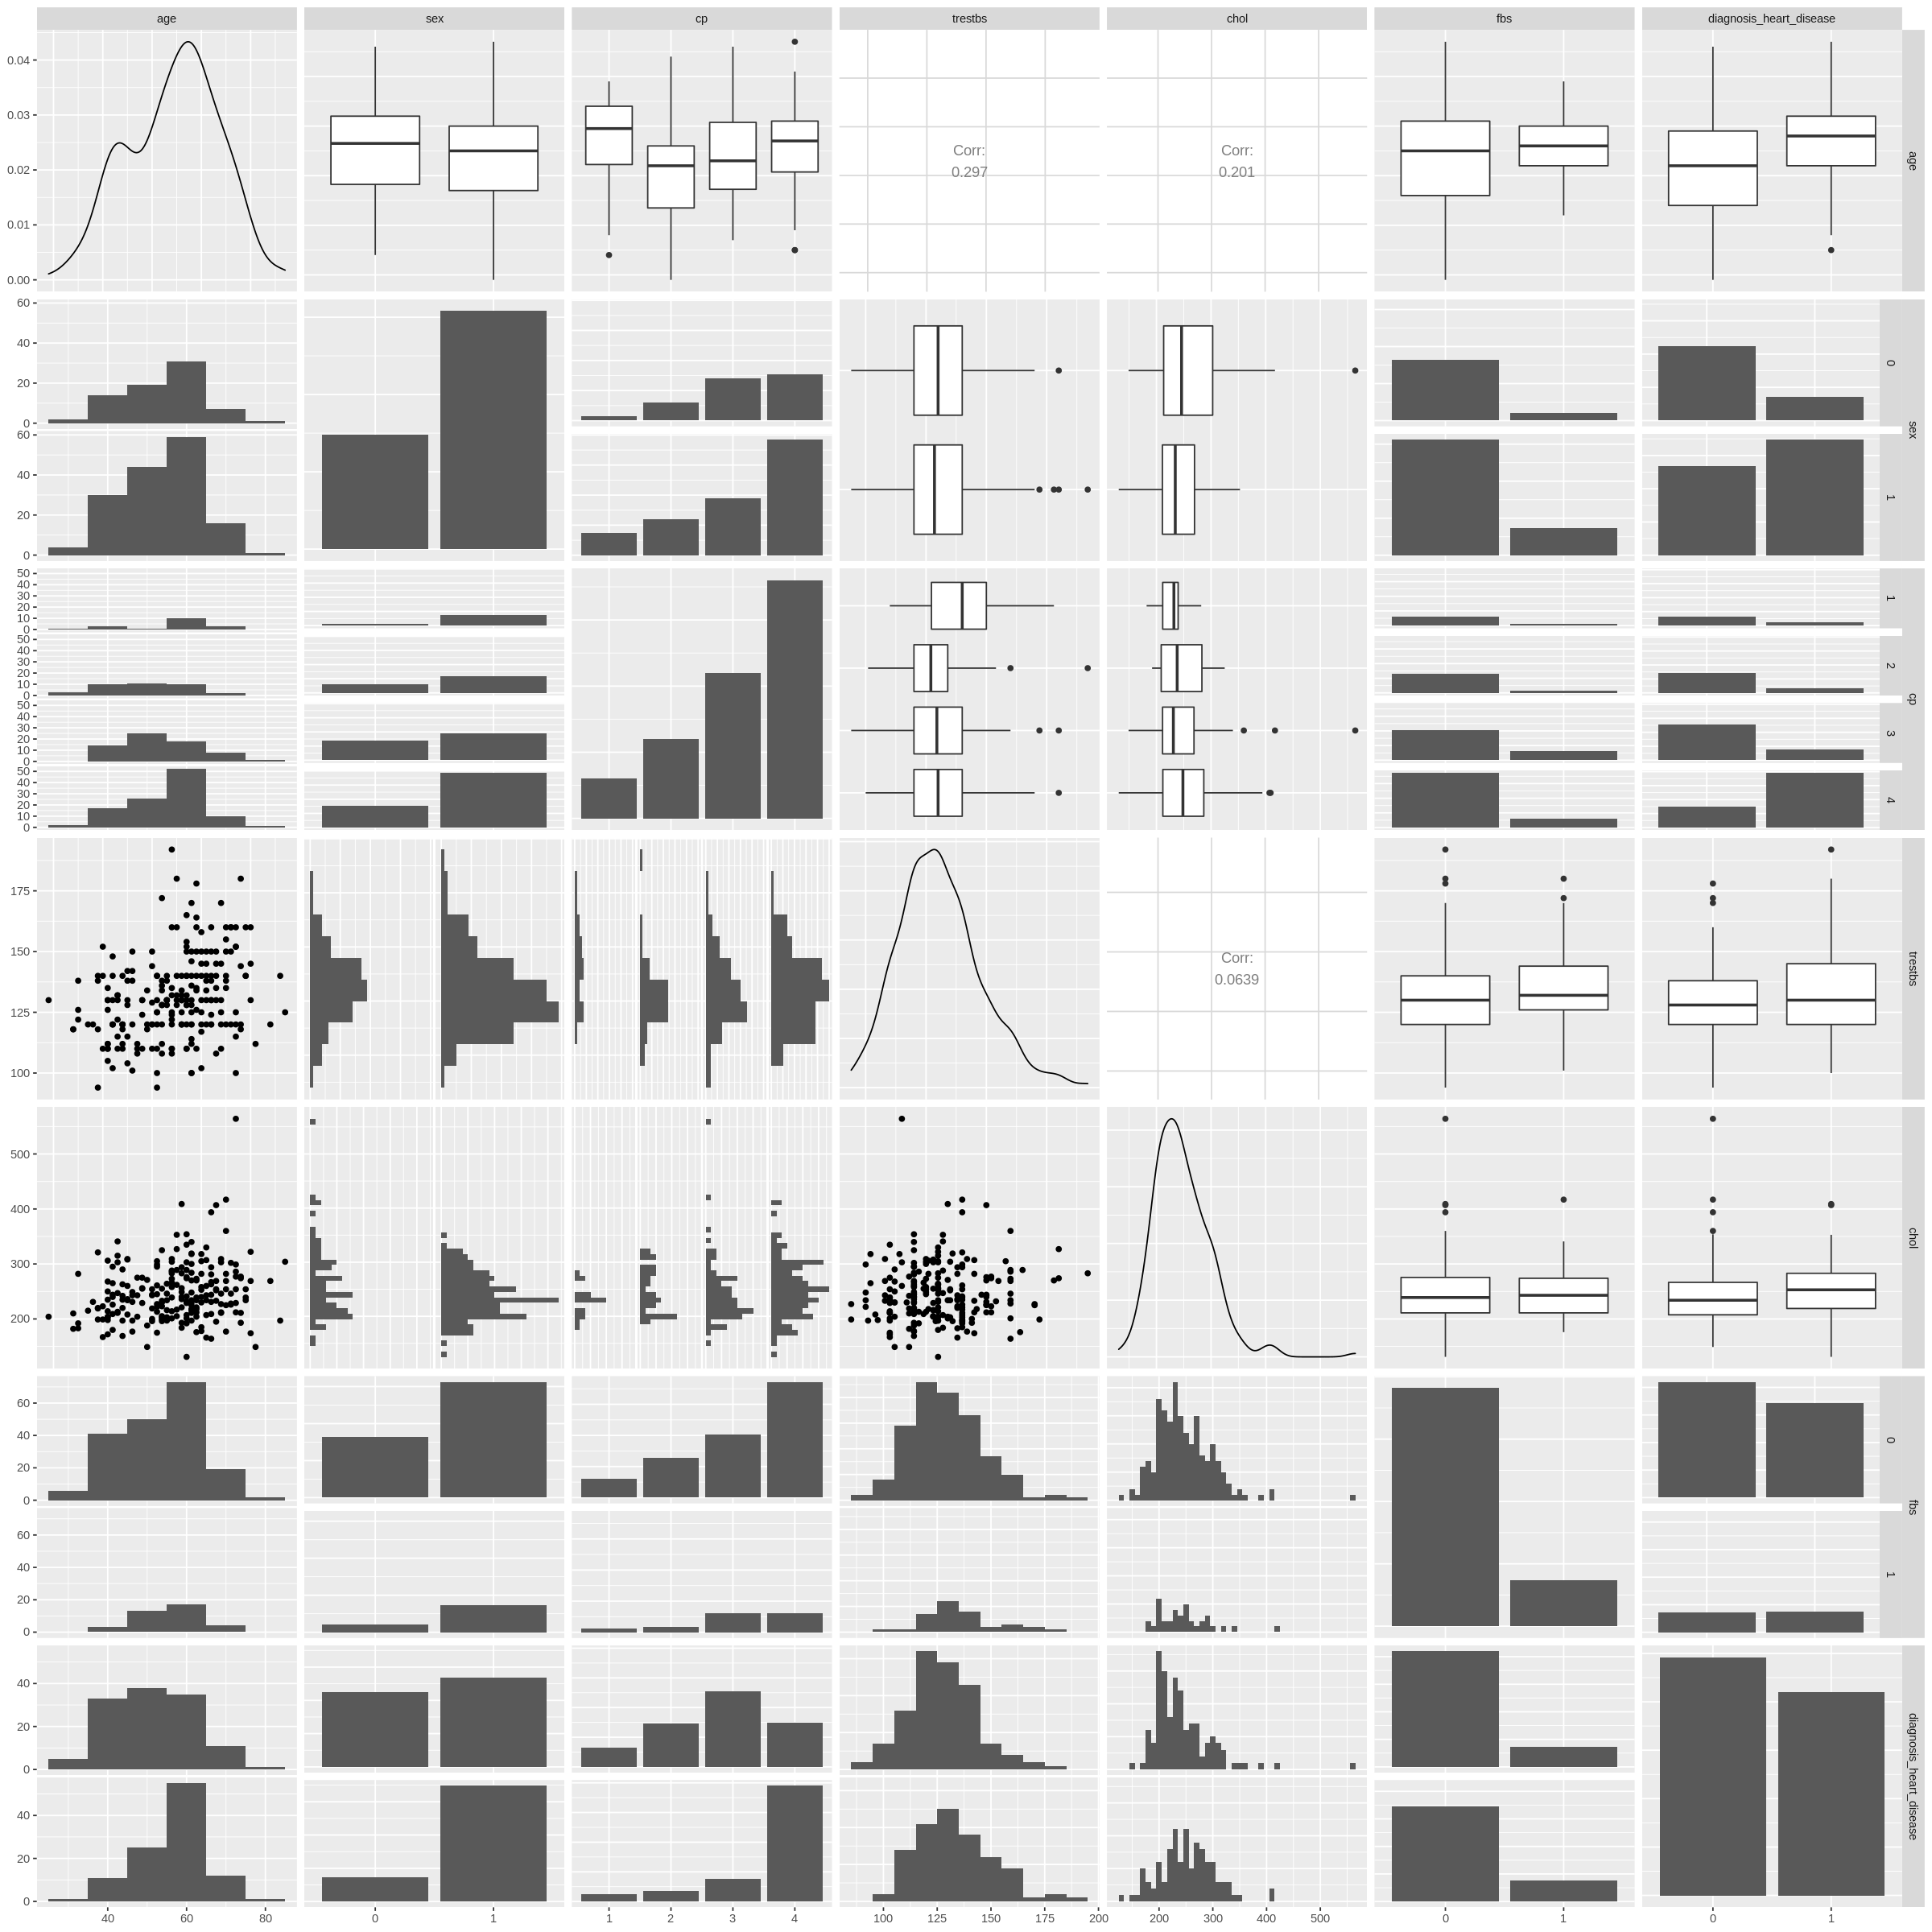

In [91]:
#adding plots for every predictor
options(repr.plot.width = 20, repr.plot.height = 20)


cleveland_train1<-select (cleveland_train, age,sex,cp,trestbs,chol,fbs,diagnosis_heart_disease)

plot_pairs1<- ggpairs(cleveland_train1, lower=list(combo=wrap("facethist",  
                     binwidth=10)))
plot_pairs1


*Figure 1.3: cleveland_train, age,sex,cp,trestbs,chol,fbs,diagnosis_heart_disease variables are plotted against each other*

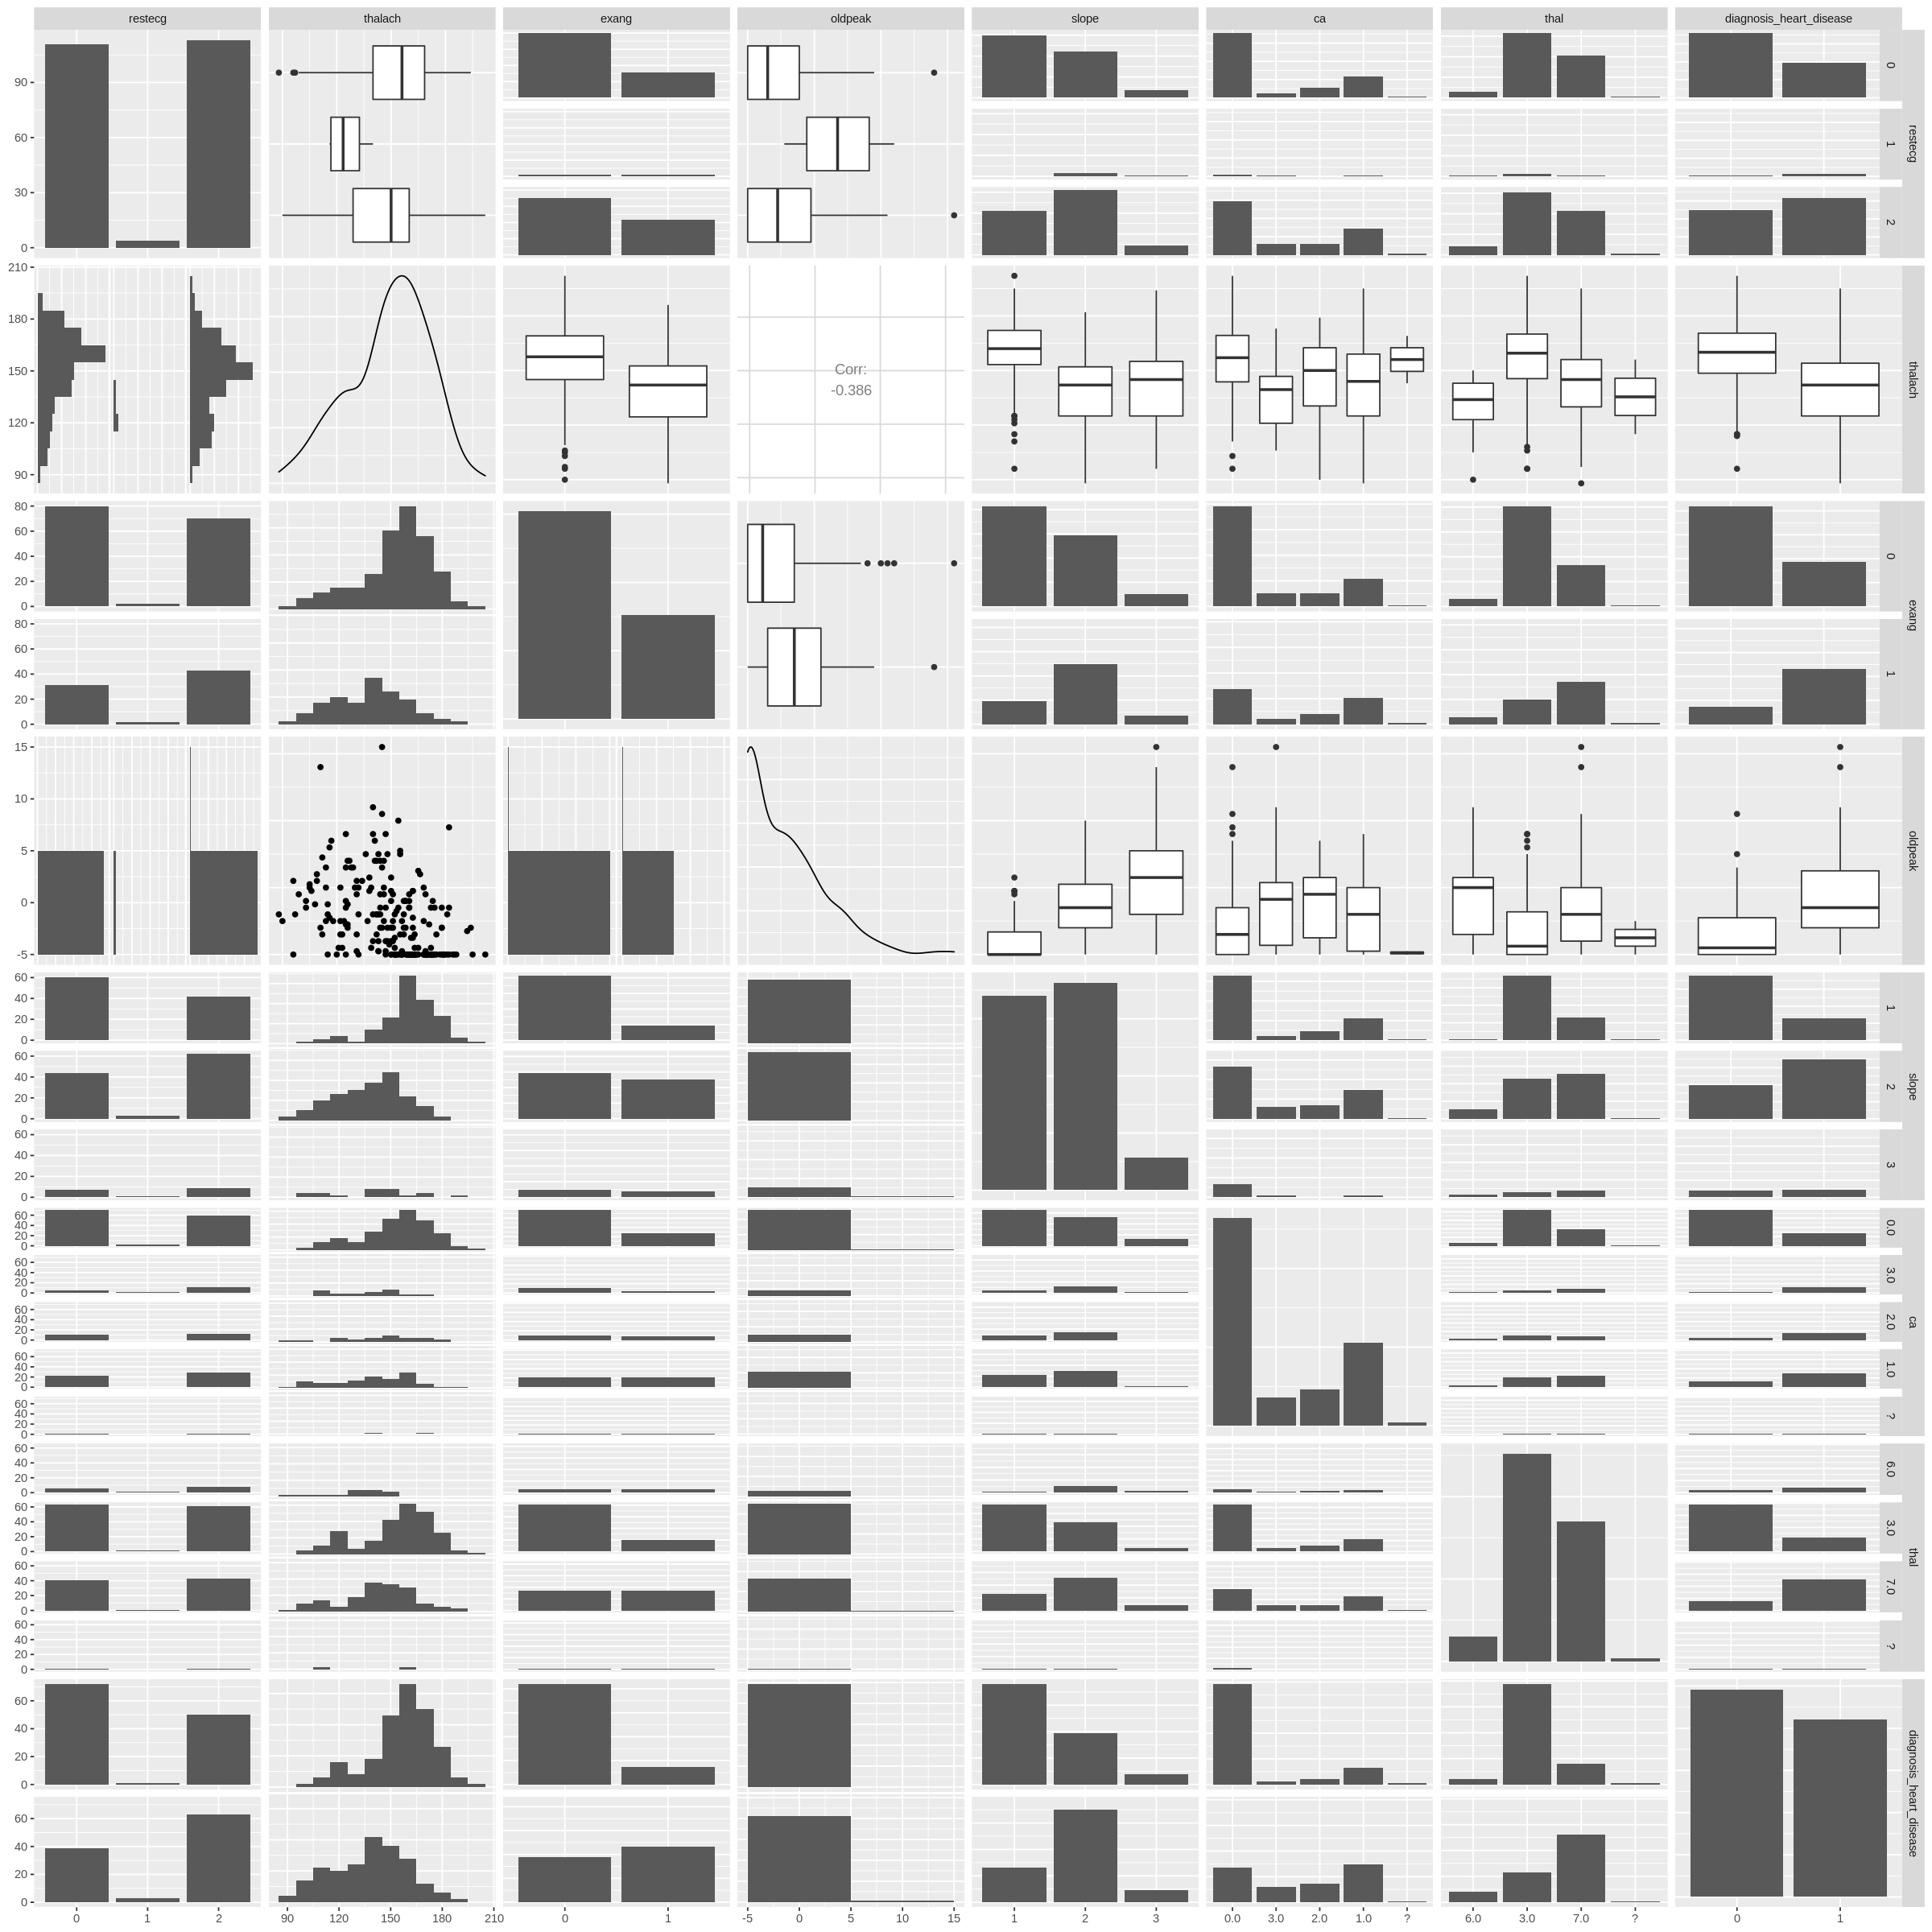

In [92]:
cleveland_train2<-select (cleveland_train, 7:14)

plot_pairs2<- ggpairs(cleveland_train2, lower=list(combo=wrap("facethist",  
                     binwidth=10)))
plot_pairs2

*Figure 1.4: restecg, thalach, exang, oldpeak, slope, ca, thal, diagnosis_heart_disease plotted against each other*

If we look at the box plot for age vs diagnosis_heart_disease, we see that the mean for a classification of 0 (no presence) is noticeably lower than the mean for a classification of 1 (has presence). Additionally, the interquartile range for 0 is wider than the interquartile range for 1, which is narrower in comparison. Based on this, we can justify that age is a good choice for our first predictor. Now, let's look at the box plot for max heart rate (thalach) vs diagnosis_heart_disease. Here, we also see that the means for a classification of 0 and 1 are noticeably different, with the mean for 0 being higher than the mean for 1. Additionally, the interquartile range for both are also noticeably different, with 0 encompassing a narrower but higher range of max heart rate compared to 1, which encompasses a wider but lower range. We'll choose thalach (max heart rate) as our second predictor due to this.

Before continuing our preliminary analysis with graphs we can summarize our data with the following table that shows the counts based on heart disease diagnosis and another table that shows the means of the predictors we chose:

In [104]:
num_of_diagnosis <- cleveland_renamed %>% 
    group_by(diagnosis_heart_disease) %>% 
    summarize(count=n()) 
num_of_diagnosis

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis_heart_disease,count
<fct>,<int>
0,164
1,139


*Figure 1.5: Summary table for the number of undiagnosed and diagnosed people in the dataset*

In [105]:
cleveland_averages <- cleveland_renamed %>% 
       summarize(thalach_mean = mean(thalach, np.rm=TRUE), age_mean = mean(age, np.rm=TRUE))

cleveland_averages

thalach_mean,age_mean
<dbl>,<dbl>
149.6073,54.43894


*Figure 1.6: Means of thalach (maximum heart rate achieved) and age in our dataset*

Now, we'll create a scatterplot between our two predictors to visualize their relationship. We'll also color each point based on their classification from diagnosis_heart_disease, with red being no presence and blue being presence. 

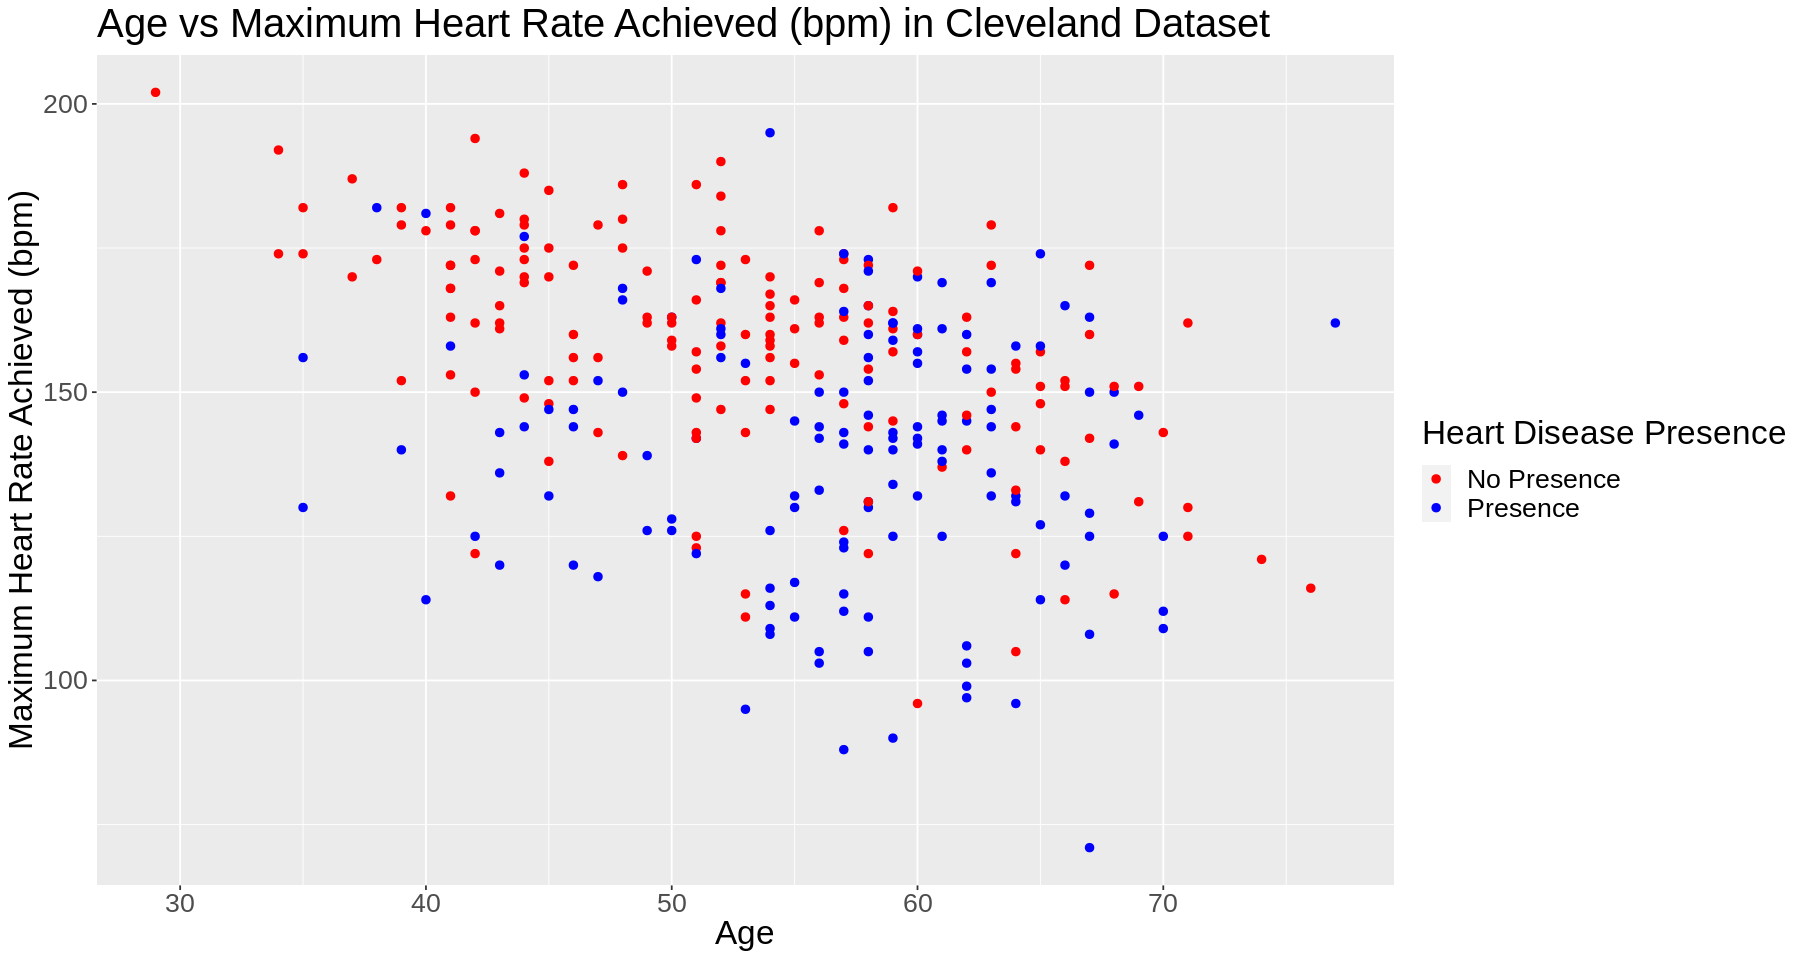

In [106]:
options(repr.plot.width = 15, repr.plot.height = 8)
cleveland_ex_plot <- cleveland_renamed %>%
    ggplot(aes(x = age, y = thalach)) + 
         geom_point(size = 2.0, aes(colour = diagnosis_heart_disease)) + 
         labs(x="Age", y="Maximum Heart Rate Achieved (bpm)", colour="Heart Disease Presence") +
         theme(text = element_text(size = 20)) +
         ggtitle("Age vs Maximum Heart Rate Achieved (bpm) in Cleveland Dataset")
 

cleveland_ex_plot+ 
scale_color_manual(labels = c("No Presence", "Presence"),
                   values = c ("red", "blue"))

*Figure 1.7 : Graph of Age vs Maximum Heart Rate Achieved (bpm)*

Here, we see that observations for no presence of heart disease tend to occur for those of a younger age, and observations for presence of heart disease tend to occur for those of an older age. Although it's not clear what the trend is for maximum heart rate achieved, we can say that a significant proportion of people with heart disease have high values for maximum heart rate achieved. 

Now, in order to see how our predictors behave in patients with heart disease, we will create two histograms. We will filter our training dataset so that we only have patients with heart disease. Creating histograms for both predictors will allow us to see any trends that occur depending on age or thalach in patients with heart disease.

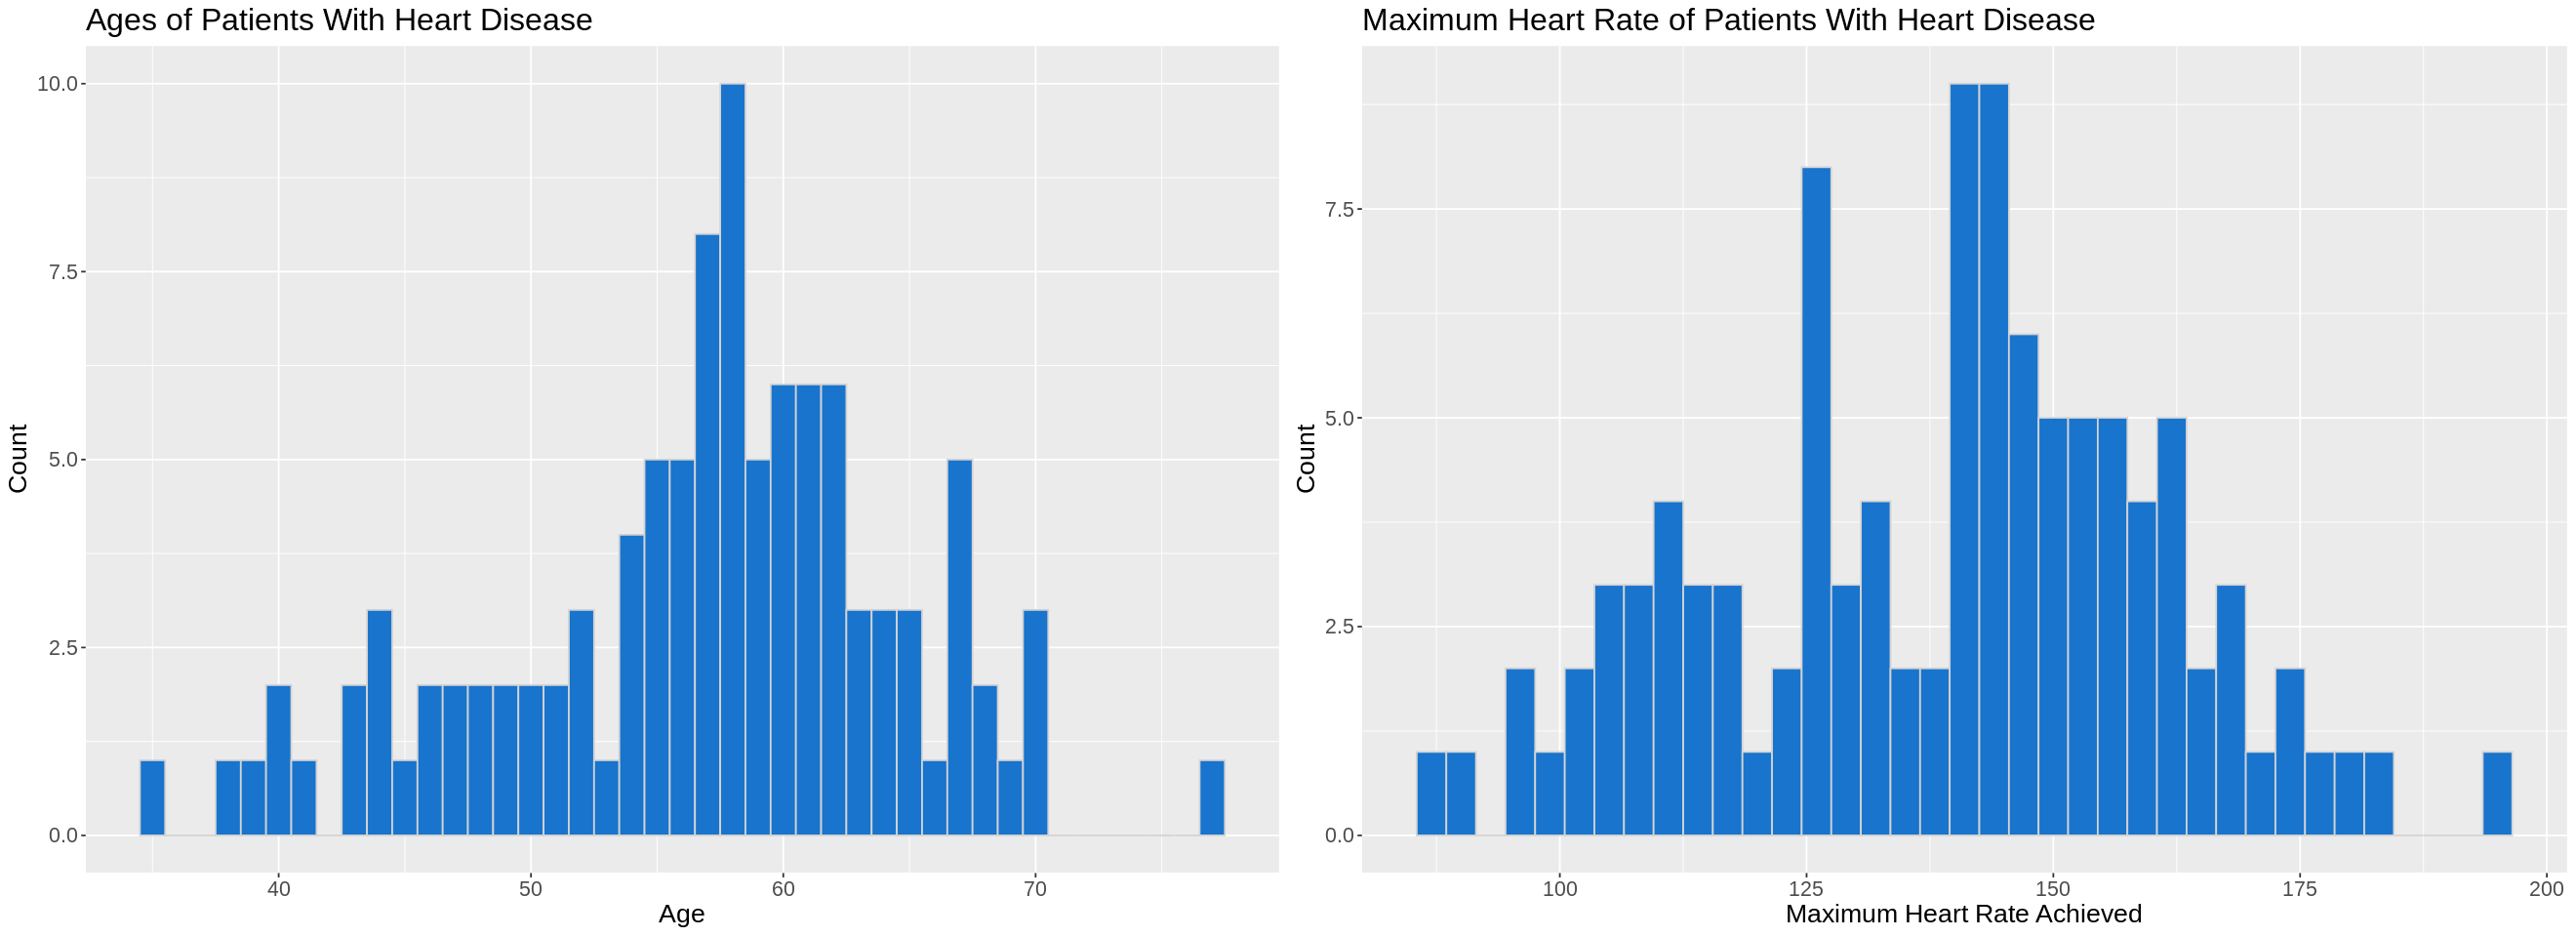

In [97]:
options(repr.plot.width = 22, repr.plot.height = 8)
#someone else justify this please
#filtering only diagnosed:

diagnosed_data<-filter(cleveland_train, diagnosis_heart_disease == "1")

diagnosed_vs_age <- ggplot(diagnosed_data, aes(x = age)) + 
    geom_histogram(fill = "dodgerblue3", color = "lightgrey", binwidth =1) +
    labs(x = "Age", y = "Count")+
    ggtitle("Ages of Patients With Heart Disease")+
    theme(text = element_text(size = 18))

diagnosed_vs_thalach <- ggplot(diagnosed_data, aes(x = thalach)) + 
    geom_histogram(fill = "dodgerblue3", color = "lightgrey", binwidth =3) +
    labs(x = "Maximum Heart Rate Achieved", y = "Count")+
    ggtitle("Maximum Heart Rate of Patients With Heart Disease")+
    theme(text = element_text(size = 18))

plot_grid(diagnosed_vs_age, diagnosed_vs_thalach, ncol = 2)


*Figure 1.8: Histograms of people with heart disease for age and thalach variables.*

Based on the graphs above we see an increase in the number of patients with heart disease as age increases until age 60. In addition, it looks like there is an increasing trend until thalach is 150.

Other than the graphs we created while choosing our predictors, we also considered scientific data. In our research we found that as we age, arteriosclerosis can occur which is an increase in stiffness of the large arteries and also causes high blood pressure due to the narrowing of the arteries, limiting blood flow to other parts of our body. The consequences of these effects are hypertension and this results in heart disease if left untreated. (“Heart Health and Aging”).

In our research we also found that heart rate has a big role in determining whether a heart is healthy, leading to our choice of maximum heart rate achieved as a predictor. (“Heart Rate as a Risk Factor for Cardiovascular Disease.”) An increase in maximum heart rate can increase the risk of heart diseases by a large margin. (“Heart Rate as a Risk Factor for Cardiovascular Disease.”) High heart rate can also be associated with higher blood pressure which leads to hypertension, potentially resulting in heart disease. (“Heart Rate and Blood Pressure: Any Possible Implications for Management of Hypertension?”)

Now, we'll start our analysis using k-nearest-neighbors to determine the if we can use age and max heart rate as predictors for determining the presence of heart disease.

# Part 2: Building the model using k-nearest neighbors and determine the accuracy of our predictors

The prediction accuracy of a model is defined as the (number of correct predictions) / (the total number of predictions). To find this, we'll need to build and train our knn model using our training set. 

Now, let's start creating our model using our training data. First, we'll preprocess our training data using a recipe, indicating that diagnosis_heart_disease is our target variable, and age and thalach are our predictors. Since k-nearest-neighbors is sensitive to the scale of our predictors, we will also standardize them by applying scaling and centering to all our predictors.

In [107]:
#choosing k
#perform some preprocessing to standardize them.

heart_recipe <- recipe(diagnosis_heart_disease ~ age + thalach, data = cleveland_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

heart_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Next, we'll set up 5-fold cross validation to evaluate our classifier diagnosis_heart_disease using vfold_cv. We split our training data into 5 evenly sized chunks, allowing us to iteratively train our model on 4 of these chunks, and test our classifier on the remaining chunk (as the validation set). This gives us 5 different choices for our validation set, allowing us to evaluate our classifier 5 times, producing 5 different accuracy estimates. We can combine these 5 accuracy estimates by taking the average of them to get a single assessment of our classifier's accuracy, which mitigates the effect of choosing an abnormal validation set. 

In [108]:
num_vfold <- vfold_cv(cleveland_train, v= 5, strata = diagnosis_heart_disease)

Next, we'll optimize the accuracy of our classifier by selecting the best k value. Since cross-validation evaluates the accuracy of diagnosis_heart_disease, we can use cross validation to evaluate an accuracy for each value of k, then select the best value of k that yields the highest accuracy. First, we'll create our model specification for k-nearest-neighbors using the nearest_neighbor function. However, instead of specifying the value of neighbors, we'll set it to tune() to indicate that we want to optimize that parameter. Since this is a classification problem, we'll set the mode to "classification" and use the R-package "kknn" to perform our k-nearest-neighbors classification. 

Now, we'll create a workflow. First, let's specify a dataframe k_vals for potential values of k-neighbors from 1 to 15. Then, we'll make our workflow, but we'll use tune_grid to fit our model for each value of k, passing k_vals to the grid argument. 

In [109]:
k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1));

knn_tune<- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
    set_engine("kknn")%>%
    set_mode("classification")

knn_workflow <- workflow()  %>%
    add_recipe(heart_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = num_vfold, grid = k_vals) 

! Fold1: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold2: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold3: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold4: internal: No observations were detected in `truth` for level(s): '2', '3...

! Fold5: internal: No observations were detected in `truth` for level(s): '2', '3...



With this, we can collect the accuracies of each k value by using collect_metrics() on our workflow and filtering for "accuracy". Let's plot these accuracies versus k as a scatterplot with a line through them. This will allow us to visualize all the accuracies of each k, and make it easier to distinguish the one with the highest accuracy. 

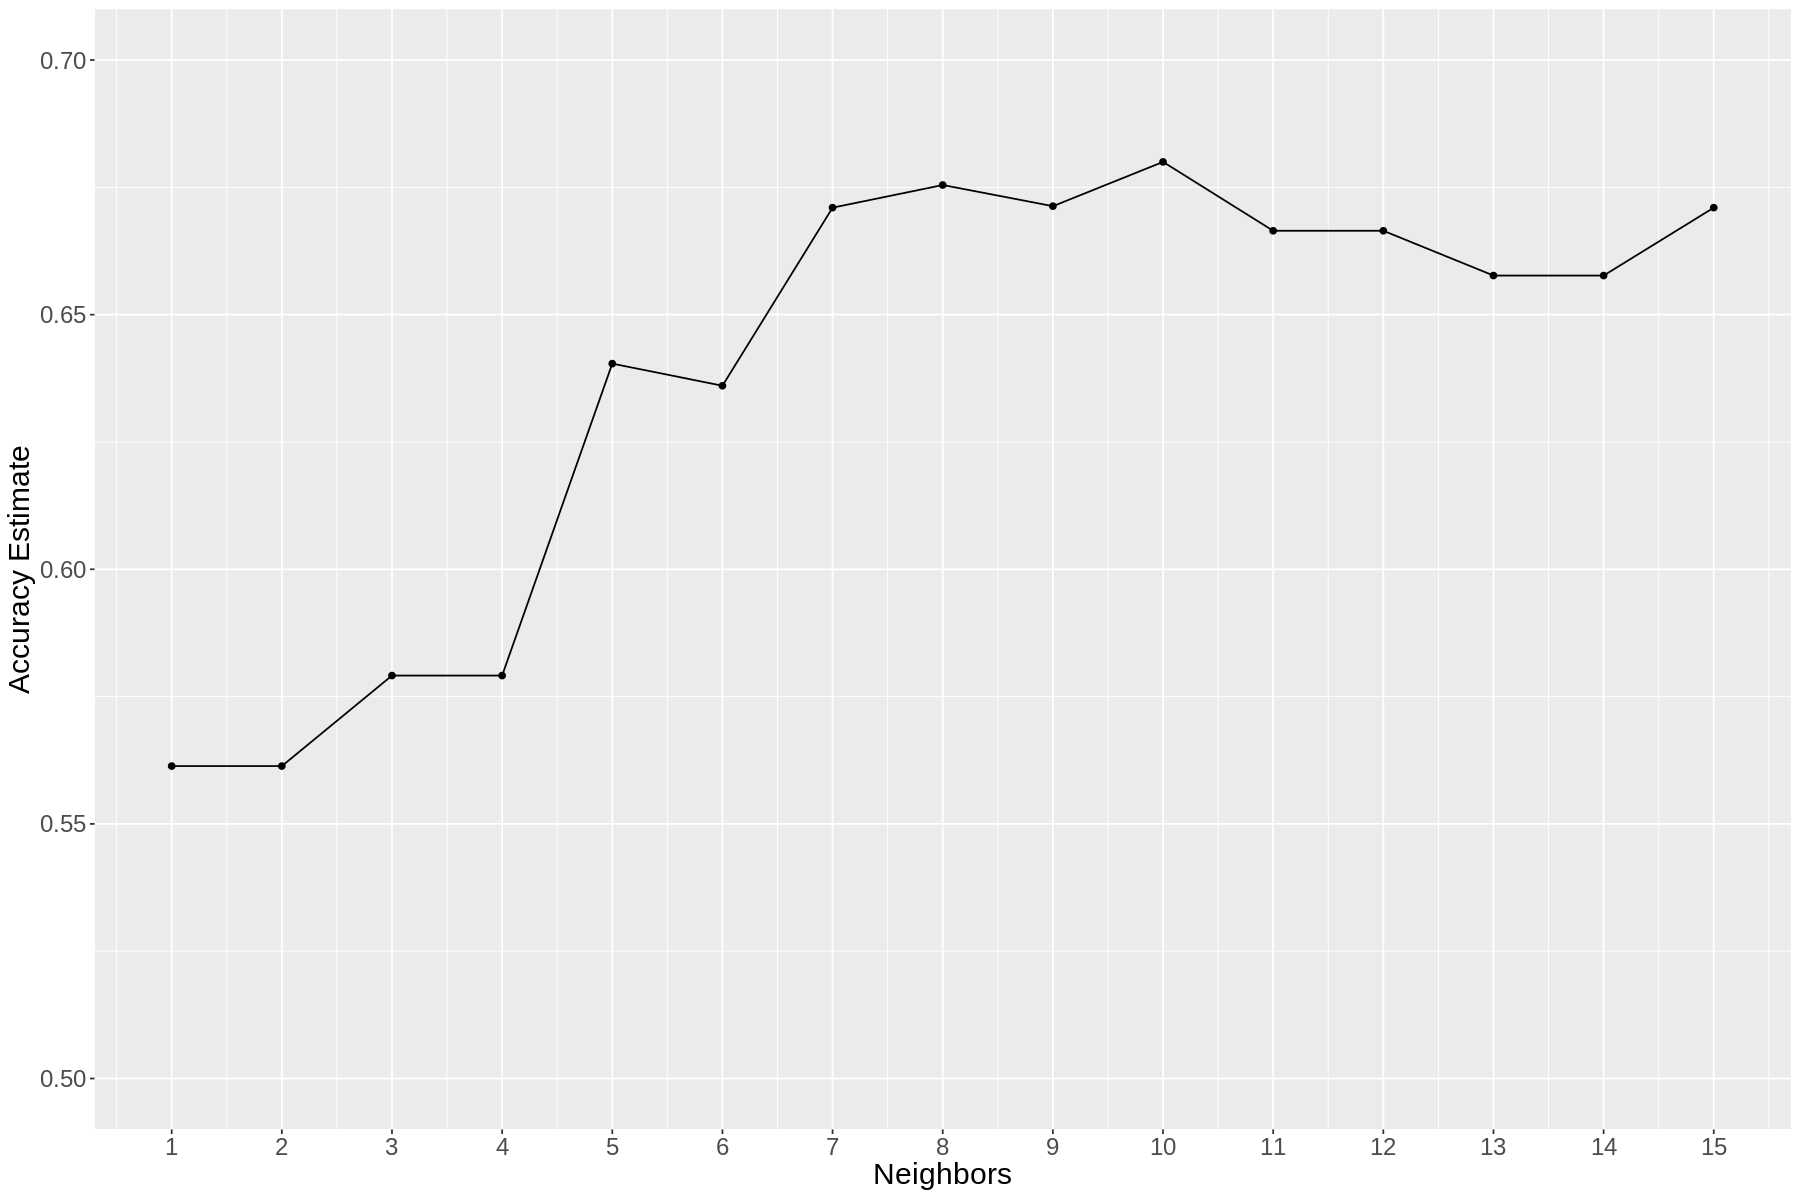

In [111]:
options(repr.plot.width = 15, repr.plot.height = 10)

accuracies <- knn_workflow %>% 
       collect_metrics() %>%
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate")+
       scale_x_continuous(breaks = seq (0, 15, 1)) +
       scale_y_continuous(limits = c(0.5, 0.7))+
       theme(text = element_text(size = 18))
       

accuracy_versus_k

Figure 2.1:Plot of estimated accuracy versus the number of neighbors

As we can see above, it seems that selecting k-neighbors = 10 will be the best choice as it provides the highest estimated accuracy. Now, we can determine an optimized value for the accuracy of our classifier. First, we'll create a new model specification heart_spec which uses the nearest_neighbor function, and specifies 10 as the number of neighbors we'll be using. Then, we'll create a new workflow using the same recipe as above and our new model specification heart_spec, and use fit() on our training data to build our classifier.

Using our optimized k-nearest neighbors classifier object for diagnosis_heart_disease, we can predict the presence of heart disease on our testing set. We do this using the predict() function.  Finally, we are able to assess the accuracy of our classifier. To do this, we'll use the metrics() function to get statistics of our model, specifiying diagnosis_heart_disease as the true value and .pred_class as the predicted value. Then, we filter for "accuracy", providing our classifier's estimated accuracy.

In [55]:
##based on the analysis our k should be k=10.

heart_spec <- nearest_neighbor(weight_func = "rectangular",neighbors = 10) %>%
    set_engine("kknn") %>%
    set_mode("classification")


heart_fit <- workflow() %>%
    add_recipe(heart_recipe) %>%
    add_model (heart_spec) %>%
    fit(data = cleveland_train)


heart_predictions<- predict (heart_fit,
                            cleveland_test) %>%
                bind_cols(cleveland_test)

heart_accuracy <- metrics(heart_predictions,
                        truth = diagnosis_heart_disease,
                        estimate = .pred_class) %>%
                  filter(.metric == "accuracy")
heart_accuracy


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.76


*Figure 2.2 : Estimated accuracy of the classifier on the test data*

From above, it shows that the estimated accuracy for our classifier using age and max heart rate was 76%. 

We can also look at a confusion matrix for our classifier using the conf_mat() function, which gives us a table of correct and wrong predictions.

In [56]:
heart_conf_mat<- heart_predictions %>%
                        conf_mat (truth = diagnosis_heart_disease,
                                 estimate = .pred_class)

heart_conf_mat

          Truth
Prediction  0  1  2  3  4
         0 30  7  0  0  0
         1 11 27  0  0  0
         2  0  0  0  0  0
         3  0  0  0  0  0
         4  0  0  0  0  0

Figure 2.3: The confusion table for our classifier.

From the above confusion matrix, we see our classifier correctly predicted 30 observations as having no presence of heart disease, and 27 observations as having a presence of heart disease. However, we had 11 false positives, and 7 false negatives.

# Part 3: Discussion

In our project, through knn-classification we found the estimated accuracy of our classifier to be 76% when we use age and max heart rate as our predictors. This looks like a good percentage but to critically analayze the performance of our classifier, we should compare our results to majority classifier. Majority classifier always guesses the the label of the majority class from the training data whithout considering the predictor variables's values. This helps us to have a sense of scale when thinking about the accuracy of our classifier.  

In [114]:
cleveland_proportions <- cleveland_train %>%
                      group_by(diagnosis_heart_disease) %>%
                      summarize(n = n()) %>%
                      mutate(percent = 100*n/nrow(cleveland_train))

cleveland_proportions

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis_heart_disease,n,percent
<fct>,<int>,<dbl>
0,123,53.94737
1,105,46.05263


In [ ]:
*Figure 3.1: Cleveland dataset proportions*

Since no heart disease represents the majority of the training data, the majority classifier would always predict that a new observation is a patient without a heart disease. Considering that the estimated accuracy of the majority classifier is close to the majority class proportion in the training data, we can expect that the majority classifier will have an accuracy of around 54%. The classifier we built produces an accuracy of 76%. This means that our classifier provides a significant improvement upon the majority classifier which indicates that at least our method is extracting some useful information from your predictor variables. In other words our classifier improved a lot on the basic majority classifier. 

However because we are trying to see if our predictors are good predictors for detecting heart disease presence, it is crutial not to produce a result of "heart disease not present" for patients who have a heart disease. In this case although a false positive would not be costly, a false negative can cause patients to not get the medical care they need which is fat worse outcome than someone being classified as having heart disease presence when they truly do not have it. 

The confusion matrix above shows that our classifier misdiagnoses 7 out of 27 (20% ) heart disease present cases. Therefore, even though we observed that accuracy improved upon the majority classifier, considering the results from confusion matrix we should be sceptical about whether our classifier has the appropriate performance for determining heart disease presence.

Overall, in our report we expected to find that our predictors would be able to determine the presence of heart disease to some extent due to the use of GGpairs to visualize how the predictors we selected would correlate to the presence of heart disease. We also expected the distribution of those in middle to older ages to have a higher presence of heart disease which is displayed in one of our histograms.

The results indicates that for future models that try to determine the presence of heart disease,  including age and thalach while selecting predictors could help strengthen the classifier. The results can also encourage future research for finding correlations between age or thalach on heart disease diagnosis. 

Lastly, a future question that this analysis could lead to can be whether we can use age and thalach to determine the severity of heart disease instead of trying to determine just the presence.




# Resources

- “Heart Disease: It Can Happen at Any Age.” Centers for Disease Control and Prevention, Centers for Disease Control and Prevention, 26 Jan. 2021, https://www.cdc.gov/heartdisease/any_age.htm. 
- “Prevention & Wellness Centre.” General Information | University of Ottawa Heart Institute | Prevention & Wellness Centre, https://pwc.ottawaheart.ca/education/heart-health-education/general-information. 
- “Types of Heart Disease.” Heart and Stroke Foundation of Canada, https://www.heartandstroke.ca/heart-disease/what-is-heart-disease/types-of-heart-disease#:~:text=Heart%20disease%20is%20any%20condition,with%20many%20different%20root%20causes. 
- “Heart Health and Aging.” National Institute on Aging, U.S. Department of Health and Human Services, 1 June 2018, https://www.nia.nih.gov/health/heart-health-and-aging#changes.
- “Tachycardia.” Mayo Clinic, Mayo Foundation for Medical Education and Research, 8 Jan. 2022, https://www.mayoclinic.org/diseases-conditions/tachycardia/symptoms-causes/syc-20355127.
- A;, Perret-Guillaume C;Joly L;Benetos. “Heart Rate as a Risk Factor for Cardiovascular Disease.” Progress in Cardiovascular Diseases, U.S. National Library of Medicine, https://pubmed.ncbi.nlm.nih.gov/19615487/.
- Reule, Scott, and Paul E Drawz. “Heart Rate and Blood Pressure: Any Possible Implications for Management of Hypertension?” Current Hypertension Reports, U.S. National Library of Medicine, Dec. 2012, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3491126/.